In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [ ]:
df = pd.read_excel('//content/Shkol1.xls',header = None)
df = df.drop([1,2],axis = 1)
df = df.dropna()
df.columns = ['price']
display(df.head())
print('\n our dataset statistics are:')
display(df.describe())

,price
0,9178.3
1,9130.5
2,9089.2
3,9023.7
4,8973.3



 our dataset statistics are:


,price
count,3.711000e+03
mean,4.820353e+05
std,7.023181e+05
min,7.955400e+03
25%,2.906550e+04
50%,7.843090e+04
75%,1.143082e+06
max,2.535236e+06


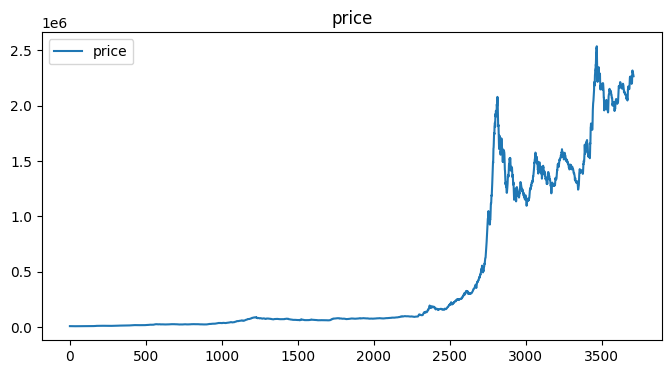

In [ ]:
# ploting data
df.plot(kind = 'line',title = 'price',figsize = (8,4))
plt.show()

as we would split our 20 last datas for test and our longest sequence length would be 50 so our first x validation would start at index 3513 and so we fit minmax normalize method until 3513 and transform rest to protect our model from data leakage

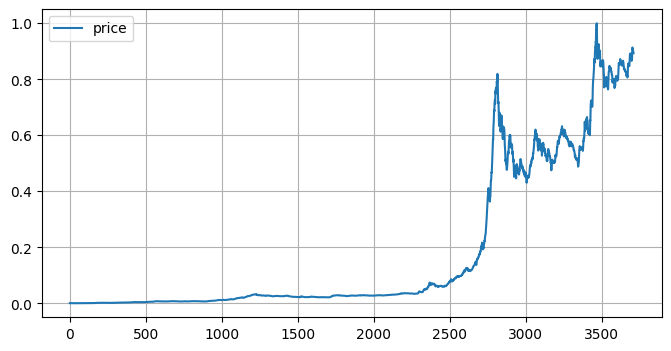

In [ ]:
normalizer = MinMaxScaler()
normalizer.fit(df[:3513])
df_norm = pd.DataFrame(normalizer.transform(df),columns = ['price'])
df_norm.plot(kind = 'line' , figsize =(8,4))
plt.grid()

prepared data in desire rnn format shape for x,y and make x and y with different sequence length to determine which input lenght is best

In [ ]:
## prepared data in shape(sequence number, step length , feature length)
def split_xy(dataset , seq_len , next_steps = 1 , final_predictions = False):
  x = []
  y = []
  if not final_predictions:
    for i in range(len(dataset)-seq_len-next_steps+1):
      x.append(dataset.price.values[i:i+seq_len])
      y.append(dataset.price.values[i+seq_len:i+seq_len+next_steps])

    x = np.array(x)
    x = x.reshape(x.shape[0],x.shape[1],1)
    y = np.array(y)
    return x , y
  ## handle function error for last outputs that we wanna predict without any target(y)
  else:
    x = []
    for i in range(21 - next_steps, 0 , -1):
      x.append(dataset.price.values[len(dataset)-seq_len-i+1:len(dataset)-i+1])
    x = np.array(x)
    x = x.reshape(x.shape[0],x.shape[1],1)
    return x
## make a different sequence length while our output have
for i in range(1,6):
  globals()[f'x{10*i}'] , globals()[f'y{10*i}'] ,  = split_xy(df_norm,10*i,20)
  globals()[f'x{10*i}'] , globals()[f'y{10*i}'] ,  globals()[f'x{10*i}_test'] , globals()[f'y{10*i}_test'] =\
  globals()[f'x{10*i}'][:-20] , globals()[f'y{10*i}'][:-20] ,  globals()[f'x{10*i}'][-20:] , globals()[f'y{10*i}'][-20:]
  print(f'our fetaure data with sequence length {10*i} after splitting test data from it have shape: {globals()[f"x{10*i}"].shape}\
  and our target shape is {globals()[f"y{i*10}"].shape}\nwith test shape {globals()[f"x{i*10}_test"].shape}')

our fetaure data with sequence length 10 after splitting test data from it have shape: (3662, 10, 1)  and our target shape is (3662, 20)
with test shape (20, 10, 1)
our fetaure data with sequence length 20 after splitting test data from it have shape: (3652, 20, 1)  and our target shape is (3652, 20)
with test shape (20, 20, 1)
our fetaure data with sequence length 30 after splitting test data from it have shape: (3642, 30, 1)  and our target shape is (3642, 20)
with test shape (20, 30, 1)
our fetaure data with sequence length 40 after splitting test data from it have shape: (3632, 40, 1)  and our target shape is (3632, 20)
with test shape (20, 40, 1)
our fetaure data with sequence length 50 after splitting test data from it have shape: (3622, 50, 1)  and our target shape is (3622, 20)
with test shape (20, 50, 1)


In [ ]:
from sklearn.model_selection import train_test_split
for i in range(1,6):
  globals()[f'x{10*i}_train'],globals()[f'x{10*i}_val'],globals()[f'y{10*i}_train'],globals()[f'y{10*i}_val'] = \
  train_test_split(globals()[f'x{10*i}'],globals()[f'y{10*i}'],shuffle = False,test_size = 0.03)
  print(f"x{i*10} train shape is :{globals()[f'x{10*i}_train'].shape} and x{10*i} test shape is: {globals()[f'x{10*i}_val'].shape}")

x10 train shape is :(3552, 10, 1) and x10 test shape is: (110, 10, 1)
x20 train shape is :(3542, 20, 1) and x20 test shape is: (110, 20, 1)
x30 train shape is :(3532, 30, 1) and x30 test shape is: (110, 30, 1)
x40 train shape is :(3523, 40, 1) and x40 test shape is: (109, 40, 1)
x50 train shape is :(3513, 50, 1) and x50 test shape is: (109, 50, 1)


our first model is in many to many structure
so we want to predict 20 steps aheadcat once

In [ ]:
from keras.layers import Dense,LSTM,GRU,SimpleRNN,Input
model_list = []
def create_model(layer):
  input = Input((50,1))
  rnn_1 = layer(50,return_sequences = True,activation = 'relu')(input)
  rnn_2 = layer(40,return_sequences = False , activation = 'relu')(rnn_1)
  output = Dense(20,activation = 'linear')(rnn_2)
  model = keras.Model(inputs = input , outputs = output)
  model.compile(loss= keras.losses.mae , optimizer = 'adam')
  model_list.append(model)
  model.summary()
  return model

model_rnn = create_model(SimpleRNN)
model_gru = create_model(GRU)
model_lstm = create_model(LSTM)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3640      
                                                                 
 dense (Dense)               (None, 20)                820       
                                                                 
Total params: 7060 (27.58 KB)
Trainable params: 7060 (27.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (

In [ ]:
model_rnn.fit(x50_train,y50_train,validation_data = (x50_val,y50_val) , epochs = 30)
model_gru.fit(x50_train,y50_train,validation_data = (x50_val,y50_val) , epochs = 30)
model_lstm.fit(x50_train,y50_train,validation_data = (x50_val,y50_val) , epochs = 30)


Epoch 1/30
110/110 [==============================] - 5s 23ms/step - loss: 0.0570 - val_loss: 0.0272
Epoch 2/30
110/110 [==============================] - 2s 19ms/step - loss: 0.0122 - val_loss: 0.0468
Epoch 3/30
110/110 [==============================] - 2s 19ms/step - loss: 0.0112 - val_loss: 0.0271
Epoch 4/30
110/110 [==============================] - 3s 27ms/step - loss: 0.0105 - val_loss: 0.0322
Epoch 5/30
110/110 [==============================] - 3s 26ms/step - loss: 0.0106 - val_loss: 0.0456
Epoch 6/30
110/110 [==============================] - 2s 19ms/step - loss: 0.0107 - val_loss: 0.0288
Epoch 7/30
110/110 [==============================] - 2s 20ms/step - loss: 0.0104 - val_loss: 0.0236
Epoch 8/30
110/110 [==============================] - 2s 19ms/step - loss: 0.0102 - val_loss: 0.0457
Epoch 9/30
110/110 [==============================] - 2s 19ms/step - loss: 0.0101 - val_loss: 0.0344
Epoch 10/30
110/110 [==============================] - 4s 32ms/step - loss: 0.0099 - val_lo

In [ ]:
print('our mae with rnn network is:',model_rnn.evaluate(x50_val,y50_val))
print('our mae with gru network is:',model_gru.evaluate(x50_val,y50_val))
print('our mae with lstm network is:',model_lstm.evaluate(x50_val,y50_val))


4/4 [==============================] - 0s 10ms/step - loss: 0.0282
our mae with rnn network is: 0.02816055528819561
4/4 [==============================] - 0s 11ms/step - loss: 0.0252
our mae with gru network is: 0.025227772071957588
4/4 [==============================] - 0s 14ms/step - loss: 0.0335
our mae with lstm network is: 0.03348584845662117


results show the excel of using gru model. now we want to determine the optimal sequence length that vary from 10 to 60 with step length of 10.

In [ ]:
## create model list contain gru models for each time sequence and fitting it
model_list = []
for i in range(1,6):
  input = Input((10*i,1))
  rnn_1 = GRU(50,return_sequences=True,activation = 'relu')(input)
  rnn_2 = GRU(40,return_sequences=False , activation = 'relu')(rnn_1)
  output = Dense(20,activation = 'linear')(rnn_2)
  model = keras.Model(inputs = input , outputs = output)
  model.compile(loss= keras.losses.mae , optimizer = 'adam')
  model.summary()
  model_list.append(model)
  x_train , x_val , y_train , y_val = globals()[f'x{10*i}_train'],globals()[f'x{10*i}_val'],globals()[f'y{10*i}_train'],globals()[f'y{10*i}_val']
  model_list[i-1].fit(x_train,y_train , validation_data = (x_val , y_val) , epochs = 30)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 gru_2 (GRU)                 (None, 10, 50)            7950      
                                                                 
 gru_3 (GRU)                 (None, 40)                11040     
                                                                 
 dense_3 (Dense)             (None, 20)                820       
                                                                 
Total params: 19810 (77.38 KB)
Trainable params: 19810 (77.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
111/111 [==============================] - 3s 12ms/step - loss: 0.0733 - val_loss: 0.0332
Epoch 2/30
111/111 [==============================] - 

In [ ]:
for i in range(1,6):
  print(f'for sequnce length {10*i} train loss is {model_list[i-1].history.history["loss"][-1]}\
  and validation loss is {model_list[i-1].history.history["val_loss"][-1]}')

for sequnce length 10 train loss is 0.009467711672186852  and validation loss is 0.03539620712399483
for sequnce length 20 train loss is 0.009199881926178932  and validation loss is 0.033737387508153915
for sequnce length 30 train loss is 0.009306412190198898  and validation loss is 0.026045555248856544
for sequnce length 40 train loss is 0.009330028668045998  and validation loss is 0.022790636867284775
for sequnce length 50 train loss is 0.009395224042236805  and validation loss is 0.03051443211734295


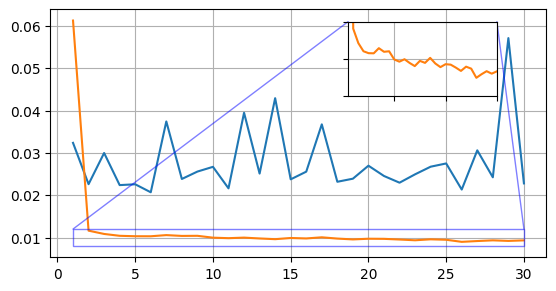

In [ ]:
fig , main_ax = plt.subplots();main_ax.set_box_aspect(0.5)
inset_ax = main_ax.inset_axes([0.6, 0.65, 0.3, 0.3],xlim = [1,30],ylim = [0.008,0.012],xticklabels=[], yticklabels=[])
for ax in main_ax,inset_ax:
  ax.plot(range(1,31),model_list[3].history.history['val_loss'])
  ax.plot(range(1,31),model_list[3].history.history['loss'])
main_ax.indicate_inset_zoom(inset_ax,edgecolor="blue")
inset_ax.grid()
plt.grid()

so we decide to proceed with gru model and 30 sequence length

as we now that one data maybe predict more than once(because our horizon prediction length is 20) we define a function to determine

1/1 [==============================] - 0s 25ms/step


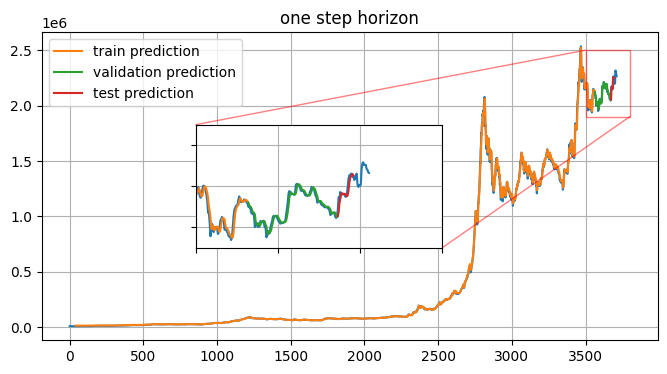

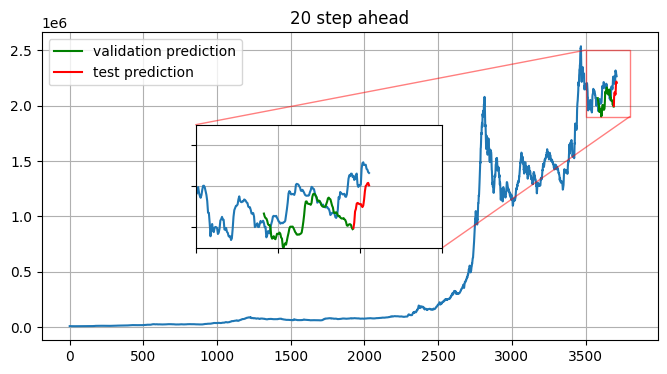

In [ ]:
def horizon_determinig(pred_data,horizon):
  data = np.zeros((pred_data.shape[0],1))
  for i in range(pred_data.shape[0]):
    data[i,0] = pred_data[i,horizon-1]

  return data
## determine best model and predict with it
final_model = model_list[3]
train_pred = final_model.predict(x40_train)
validation_pred = final_model.predict(x40_val)
test_pred = final_model.predict(x40_test)
## inverse transform from normalize data
train_pred = normalizer.inverse_transform(train_pred)
validation_pred = normalizer.inverse_transform(validation_pred)
test_pred = normalizer.inverse_transform(test_pred)
## defining our horizon on first step(1) prediction and plot it
train_pred1 = horizon_determinig(train_pred,1)
validation_pred1 = horizon_determinig(validation_pred,1)
test_pred1 = horizon_determinig(test_pred,1)

fig2 , main_ax2 = plt.subplots(figsize = (8,4));main_ax2.set_box_aspect(0.5)
inset_ax = main_ax2.inset_axes([0.25, 0.3, 0.4, 0.4],xlim = [3500,3800],
                               ylim = [1.9*np.power(10,6),2.5*np.power(10,6)],xticklabels=[], yticklabels=[])
for ax in main_ax2,inset_ax:
  ax.plot(range(1,len(df)+1),df.price)
  ax.plot(range(41,len(train_pred1)+41),train_pred1, label = 'train prediction')
  ax.plot(range(41+len(train_pred1),len(train_pred1)+len(validation_pred1)+41),validation_pred1, label = 'validation prediction')
  ax.plot(range(41+len(train_pred1)+len(validation_pred1),len(train_pred1)+len(validation_pred1)+len(test_pred1)+41),test_pred1, label = 'test prediction')
# plt.plot(range(31,len(train_pred1)+31),train_pred1, label = 'train prediction')
# plt.plot(range(31+len(train_pred1),len(train_pred1)+len(validation_pred1)+31),validation_pred1, label = 'validation prediction')
# plt.plot(range(31+len(train_pred1)+len(validation_pred1),len(train_pred1)+len(validation_pred1)+len(test_pred1)+31),test_pred1, label = 'test prediction')
main_ax2.indicate_inset_zoom(inset_ax,edgecolor="red")
inset_ax.grid()
plt.legend()
plt.title('one step horizon')
plt.grid()
plt.show()
print('\n'*3)
## defining our horizon at last step(20) prediction and plot it
# train_pred20 = horizon_determinig(train_pred,20)
# validation_pred20 = horizon_determinig(validation_pred,20)
# test_pred20 = horizon_determinig(test_pred,20)
# df.plot(kind = 'line')
# plt.plot(range(31+19,len(train_pred20)+19+31),train_pred1, label = 'train prediction')
# plt.plot(range(31+len(train_pred20)+19,len(train_pred20)+len(validation_pred20)+31+19),validation_pred1, label = 'validation prediction')
# plt.plot(range(31+len(train_pred20)+len(validation_pred20)+19,len(train_pred20)+len(validation_pred20)+len(test_pred20)+31+19),test_pred1, label = 'test prediction')
# plt.legend()
# plt.title('20 step horizon')
# plt.show()

fig3 , main_ax3 = plt.subplots(figsize = (8,4));main_ax3.set_box_aspect(0.5)
inset_ax = main_ax3.inset_axes([0.25, 0.3, 0.4, 0.4],xlim = [3500,3800],
                               ylim = [1.9*np.power(10,6),2.5*np.power(10,6)],xticklabels=[], yticklabels=[])
train_pred20 = horizon_determinig(train_pred,20)
validation_pred20 = horizon_determinig(validation_pred,20)
test_pred20 = horizon_determinig(test_pred,20)
for ax in main_ax3,inset_ax:
  ax.plot(range(1,len(df)+1),df.price)
  ax.plot(range(41+len(train_pred20)+19,len(train_pred20)+len(validation_pred20)+41+19),validation_pred20, label = 'validation prediction',color = 'green')
  ax.plot(range(41+len(train_pred20)+len(validation_pred20)+19,len(train_pred20)+len(validation_pred20)+len(test_pred20)+41+19),test_pred20, label = 'test prediction',color = 'red')

  # ax.plot(range(1,31),model_list[2].history.history['loss'])
main_ax3.indicate_inset_zoom(inset_ax,edgecolor="red")
inset_ax.grid()
plt.grid()
plt.legend()
plt.title('20 step ahead')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
y_one_step_ahead = normalizer.inverse_transform(y40_test[0].reshape(-1,1))
y_20_step_ahead = normalizer.inverse_transform(y40_test[-1].reshape(-1,1))
one_step_mae = mean_absolute_error(y_one_step_ahead,test_pred1)
twenty_step_mae = mean_absolute_error(y_20_step_ahead,test_pred20)

print(f'for ine step ahead prediction we have mae: {one_step_mae} and for 20 step ahead we have: {twenty_step_mae}')

for ine step ahead prediction we have mae: 19351.868750000034 and for 20 step ahead we have: 132122.27625000005


predict what was wanted in excel for Shkol1 and concatenate it to our excel

In [ ]:
x_last = split_xy(df_norm,30,next_steps = 20 , final_predictions = True)
y_last = normalizer.inverse_transform(model_list[2].predict(x_last))
df.concat(y_last)

1/1 [==============================] - 0s 47ms/step


AttributeError: 'DataFrame' object has no attribute 'concat'

In [ ]:
pd.DataFrame(y_last.transpose(),columns = ['price'])

,price
0,2269191.50
1,2257063.25
2,2250460.50
3,2226297.00
4,2236890.50
5,2203938.75
6,2208056.75
7,2188560.25
8,2191146.75
9,2201662.50


In [ ]:
final_df = pd.concat([df , pd.DataFrame(y_last.transpose(),columns = ['price'])],ignore_index = True)
display(final_df)
final_df.to_csv('final_df.csv')

,price
0,9178.30
1,9130.50
2,9089.20
3,9023.70
4,8973.30
...,...
3726,2175822.50
3727,2184365.75
3728,2194532.00
3729,2173456.25
